# load data

In [18]:
import awswrangler  as wr
import pandas as pd
import pymysql
import datetime
import json

In [19]:
sql = """
with raw as (
select
a.id
, a.status
, b.net
, b.mvno
, b.order_type
, b.order_type_detail
, b.completed_at
, b.reg_ts
, b.diff_hour_start_comp
, c.is_final
, c.final_type
from moyo_order.mobile_plan_order a
join moyo_mart.order_raw b on a.id = b.order_id
join moyo_mart.order_statuskr_v1 c on a.status = c.status
where 1=1
    and date(b.reg_ts ) between date('2023-01-01') and date('2023-05-31') -- 30이상 지난 악성 재고는 미결 상태를 취소로 간주함 (2021-05-31)
    and b.order_type in ( 'register', 'self')
)
select
mvno
, date_trunc('week', reg_ts) as week
, net
, count( case when order_type = 'self' then 1 end ) as self_cnt
, count( 1) all_cnt
,1.00*  count( case when order_type = 'self' then 1 end ) / count( 1) as self_ratio
, count( completed_at ) as comp_cnt
,1.00*  count( completed_at ) / count( 1) as comp_ratio
from raw
where 1=1
group by 1,2, 3
"""
df = wr.athena.read_sql_query(sql=sql, database="moyo_order")

## data check

In [20]:
df.head()

,mvno,week,net,self_cnt,all_cnt,self_ratio,comp_cnt,comp_ratio
0,이야기모바일,2023-03-27,LGU,0,323,0.000000,187,0.578947
1,이야기모바일,2023-02-06,LGU,0,527,0.000000,375,0.711575
2,이야기모바일,2023-02-27,SKT,0,53,0.000000,25,0.471698
3,이야기모바일,2023-03-20,SKT,0,44,0.000000,31,0.704545
4,이야기모바일,2023-05-22,LGU,141,508,0.277559,370,0.728346


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   mvno        315 non-null    string        
 1   week        315 non-null    datetime64[ns]
 2   net         315 non-null    string        
 3   self_cnt    315 non-null    Int64         
 4   all_cnt     315 non-null    Int64         
 5   self_ratio  315 non-null    float64       
 6   comp_cnt    315 non-null    Int64         
 7   comp_ratio  315 non-null    float64       
dtypes: Int64(3), datetime64[ns](1), float64(2), string(2)
memory usage: 20.7 KB


In [22]:
#distinct mvno
mvno_list = df.mvno.unique().tolist()

In [23]:
mvno_list

['이야기모바일',
 '이지모바일',
 'smartel',
 'insmobile',
 'marvelring',
 'sugarmobile',
 '사람과연결',
 'valuecomm',
 'pointplus',
 'KTskylife',
 '에르엘',
 '위너스텔',
 '미니게이트']

In [17]:
# filter zroe self_ratio 
df_nozero = df[df.self_ratio != 0]
df_zero = df[df.self_ratio == 0]


In [14]:
# korean font setting
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/Library/Fr

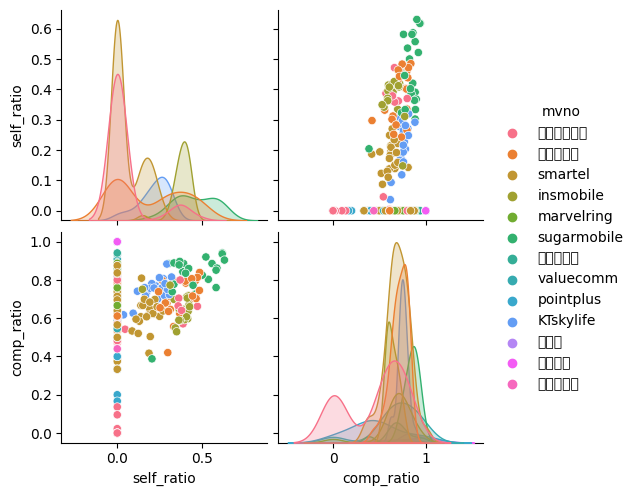

In [24]:
#pair plot of self_ratio and comp_ratio 
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, hue="mvno", vars=["self_ratio", "comp_ratio"])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


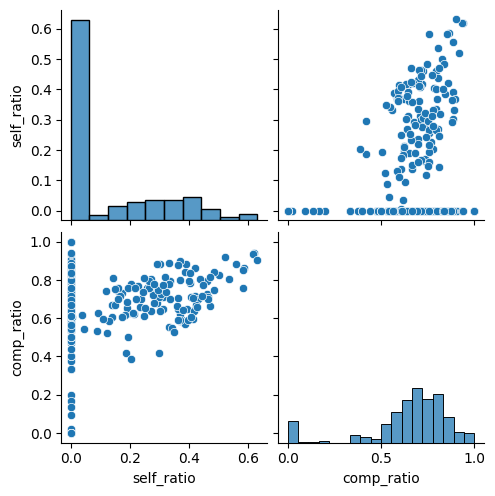

In [25]:
#pair plot of self_ratio and comp_ratio 
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df,  vars=["self_ratio", "comp_ratio"])
plt.show()

In [ ]:
#pair plot of self_ratio and comp_ratio 
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df,  vars=["self_ratio", "comp_ratio"])
plt.show()

In [27]:
# df_nozero avg comp_ratio by mvno & net 
df_nozero.groupby(['mvno','net'])['comp_ratio'].mean().reset_index()

,mvno,net,comp_ratio
0,KTskylife,KT,0.749004
1,insmobile,LGU,0.637307
2,smartel,LGU,0.625478
3,sugarmobile,LGU,0.828945
4,이야기모바일,LGU,0.658027
5,이지모바일,LGU,0.710916


In [28]:
df_zero.groupby(['mvno','net'])['comp_ratio'].mean().reset_index()

,mvno,net,comp_ratio


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:500: FutureWar

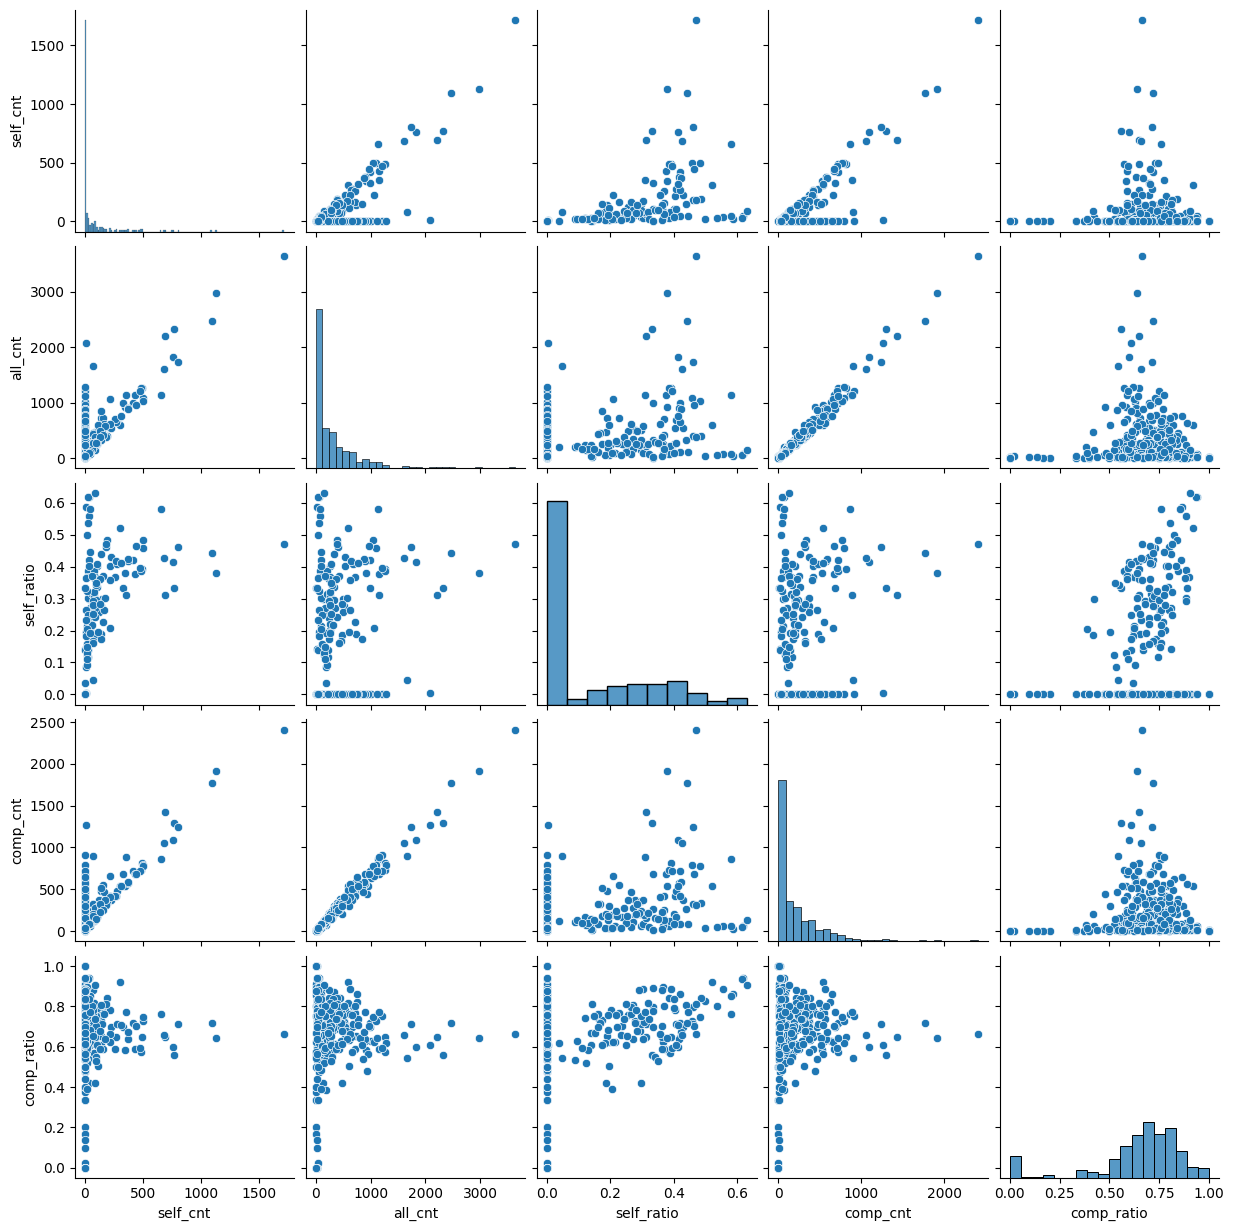

In [29]:
sns.pairplot(df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/distributions.py:500: FutureWar

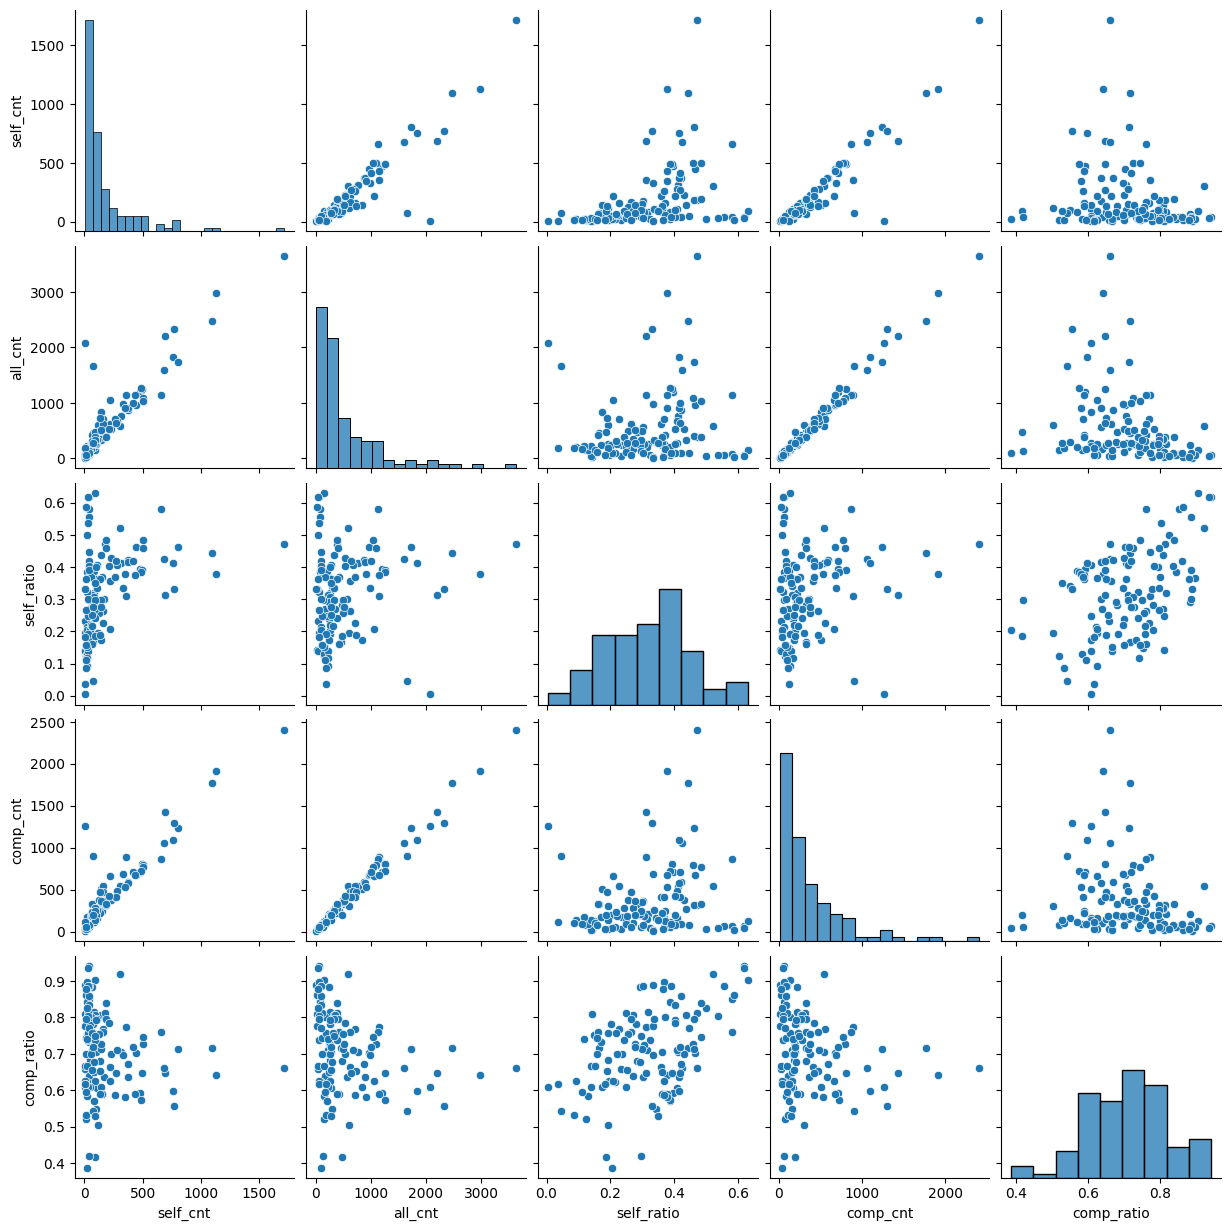

In [30]:
sns.pairplot(df_nozero)

In [33]:
corr = df_nozero.corr(method='pearson')

/var/folders/df/cs55_cks0_3_zx14p6v7h1_h0000gn/T/ipykernel_43035/403312000.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_nozero.corr(method='pearson')


In [34]:
corr

,self_cnt,all_cnt,self_ratio,comp_cnt,comp_ratio
self_cnt,1.000000,0.912897,0.366528,0.930561,-0.154988
all_cnt,0.912897,1.000000,0.137210,0.991755,-0.272040
self_ratio,0.366528,0.137210,1.000000,0.179677,0.448784
comp_cnt,0.930561,0.991755,0.179677,1.000000,-0.196883
comp_ratio,-0.154988,-0.272040,0.448784,-0.196883,1.000000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.draw()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/utils.py:80: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  fig.canvas.draw()
/Library/Fr

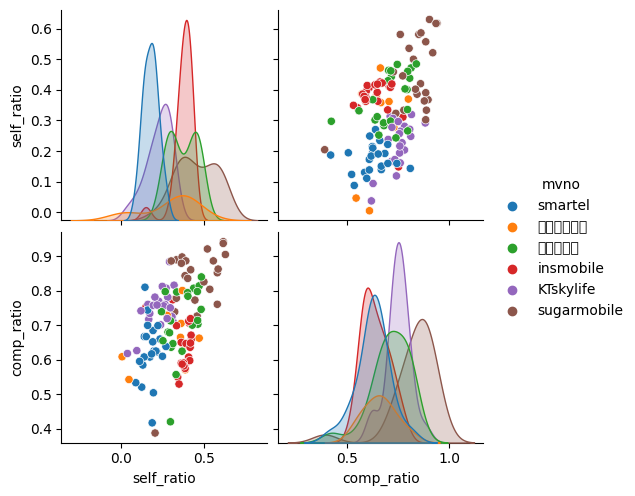

In [35]:
#pair plot of self_ratio and comp_ratio 
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_nozero, hue="mvno", vars=["self_ratio", "comp_ratio"])
plt.show()

In [37]:
# avg comp_ratio  and self_ratio by mvno & net
df.groupby(['mvno','net'])['comp_ratio','self_ratio'].mean().reset_index()

/var/folders/df/cs55_cks0_3_zx14p6v7h1_h0000gn/T/ipykernel_43035/2699996691.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['mvno','net'])['comp_ratio','self_ratio'].mean().reset_index()


,mvno,net,comp_ratio,self_ratio
0,KTskylife,KT,0.747295,0.215195
1,insmobile,LGU,0.637307,0.374706
2,marvelring,LGU,0.683056,0.000000
3,pointplus,KT,0.463536,0.000000
4,smartel,KT,0.698521,0.000000
5,smartel,LGU,0.625478,0.176157
6,smartel,SKT,0.745975,0.000000
7,sugarmobile,LGU,0.828945,0.454656
8,valuecomm,KT,0.000000,0.000000
9,valuecomm,LGU,0.749374,0.000000


In [38]:
# sort by comp_ratio
df.groupby(['mvno','net'])['comp_ratio','self_ratio'].mean().reset_index().sort_values(by=['comp_ratio'], ascending=False)

/var/folders/df/cs55_cks0_3_zx14p6v7h1_h0000gn/T/ipykernel_43035/1465287923.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['mvno','net'])['comp_ratio','self_ratio'].mean().reset_index().sort_values(by=['comp_ratio'], ascending=False)


,mvno,net,comp_ratio,self_ratio
13,위너스텔,LGU,0.875000,0.000000
12,에르엘,LGU,0.872626,0.000000
7,sugarmobile,LGU,0.828945,0.454656
9,valuecomm,LGU,0.749374,0.000000
0,KTskylife,KT,0.747295,0.215195
6,smartel,SKT,0.745975,0.000000
11,사람과연결,LGU,0.730786,0.000000
18,이지모바일,LGU,0.710916,0.370314
17,이지모바일,KT,0.705941,0.000000
4,smartel,KT,0.698521,0.000000


In [40]:
# avg comp_ratio  and self_ratio  and sum of comp_cnt by mvno & net sorted by comp_ratio
df.groupby(['mvno','net'])['comp_ratio','self_ratio','comp_cnt'].agg({'comp_ratio':'mean','self_ratio':'mean','comp_cnt':'sum'}).reset_index().sort_values(by=['comp_ratio'], ascending=False)


/var/folders/df/cs55_cks0_3_zx14p6v7h1_h0000gn/T/ipykernel_43035/1789899724.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['mvno','net'])['comp_ratio','self_ratio','comp_cnt'].agg({'comp_ratio':'mean','self_ratio':'mean','comp_cnt':'sum'}).reset_index().sort_values(by=['comp_ratio'], ascending=False)


,mvno,net,comp_ratio,self_ratio,comp_cnt
13,위너스텔,LGU,0.875000,0.000000,9
12,에르엘,LGU,0.872626,0.000000,840
7,sugarmobile,LGU,0.828945,0.454656,3345
9,valuecomm,LGU,0.749374,0.000000,239
0,KTskylife,KT,0.747295,0.215195,5188
6,smartel,SKT,0.745975,0.000000,3374
11,사람과연결,LGU,0.730786,0.000000,1600
18,이지모바일,LGU,0.710916,0.370314,11649
17,이지모바일,KT,0.705941,0.000000,8250
4,smartel,KT,0.698521,0.000000,360


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: s must be a scalar, or float array-like with the same size as x and y

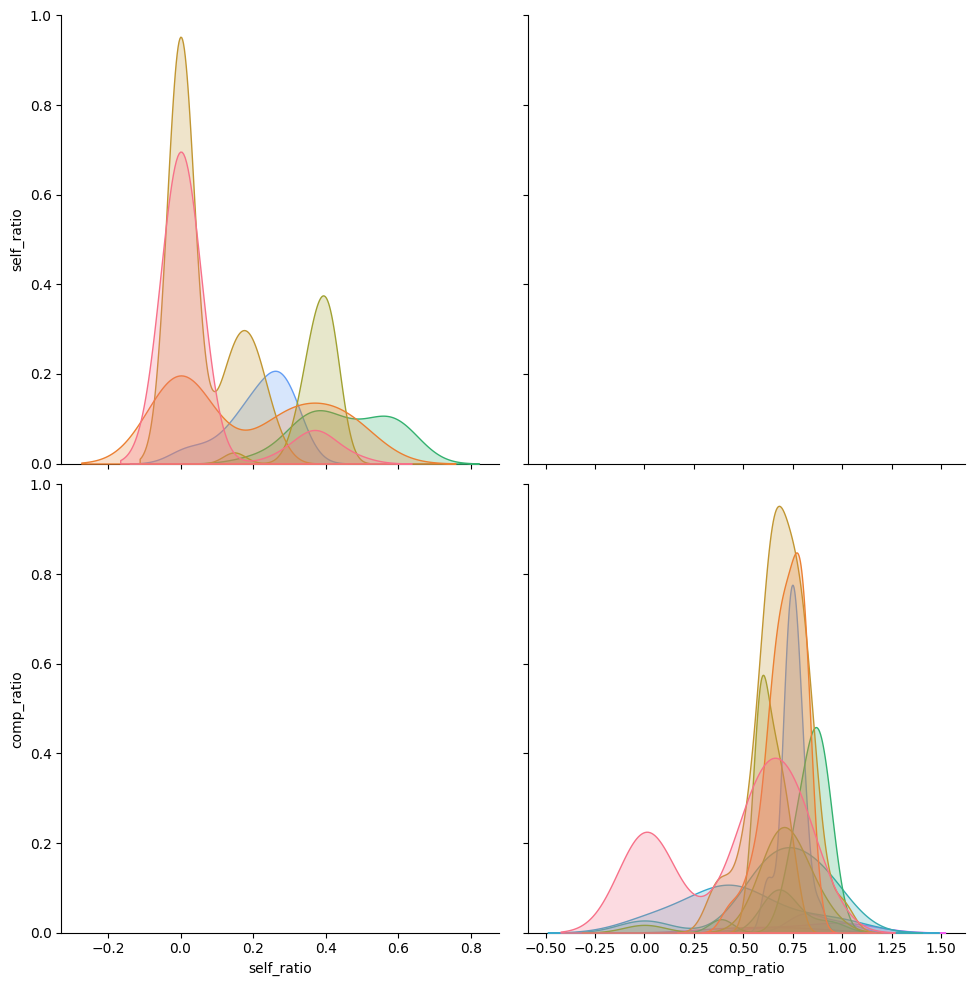

In [42]:
#pair plot of self_ratio and comp_ratio scatter size by comp_cnt
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, hue="mvno", vars=["self_ratio", "comp_ratio"], size=5, plot_kws={"s": df["comp_cnt"]})
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


ValueError: s must be a scalar, or float array-like with the same size as x and y

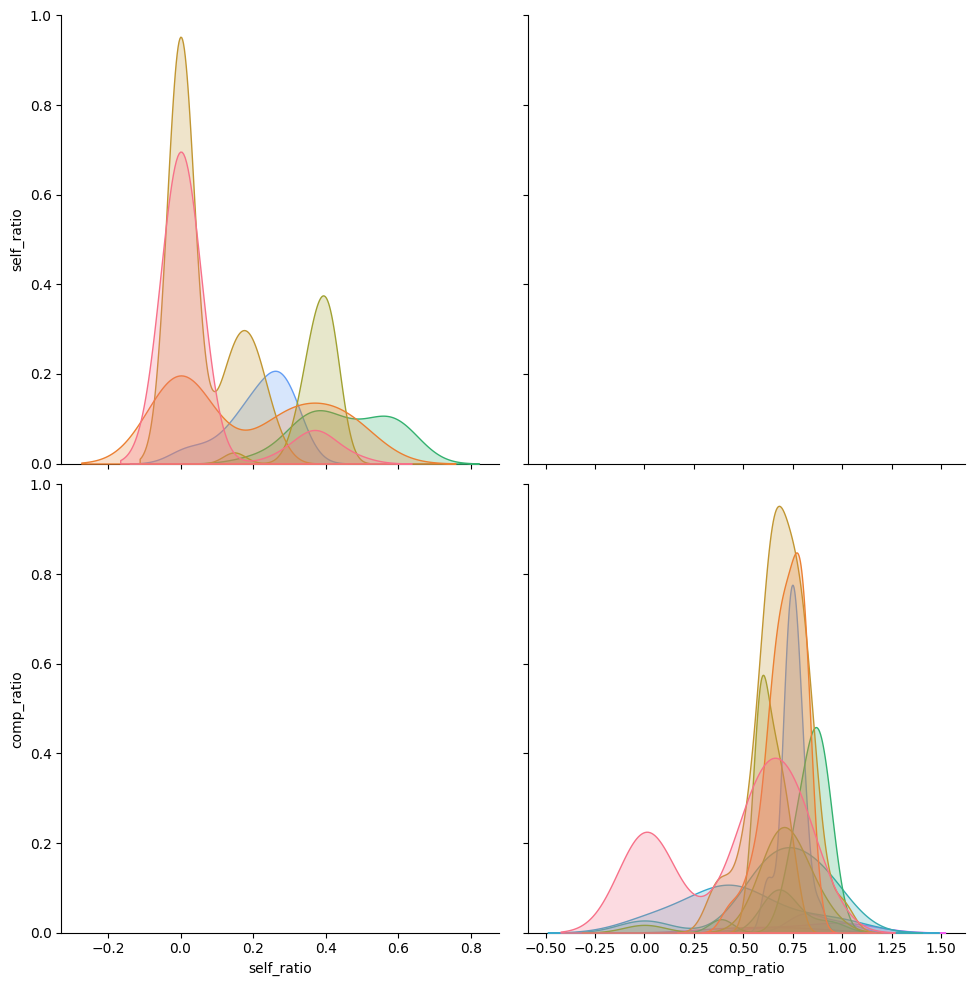

In [43]:
df = df.dropna(subset=["comp_cnt", "self_ratio", "comp_ratio"])

sns.pairplot(df, hue="mvno", vars=["self_ratio", "comp_ratio"], size=5, plot_kws={"s": df["comp_cnt"]})
plt.show()


TypeError: Cannot interpret 'Int64Dtype()' as a data type

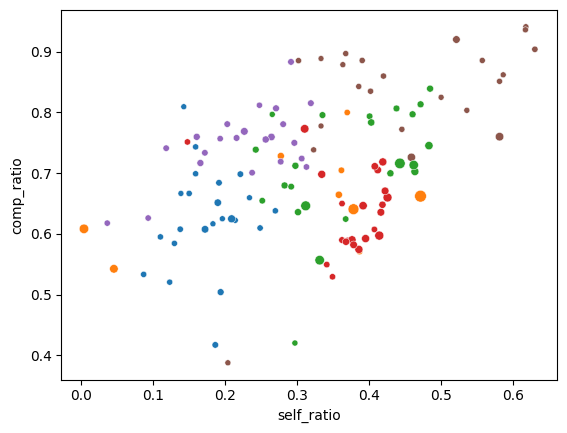

In [45]:
#scatter  plot of self_ratio and comp_ratio scatter size by comp_cnt
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_nozero, x="self_ratio", y="comp_ratio", size="comp_cnt", hue="mvno")
plt.show()

/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missi

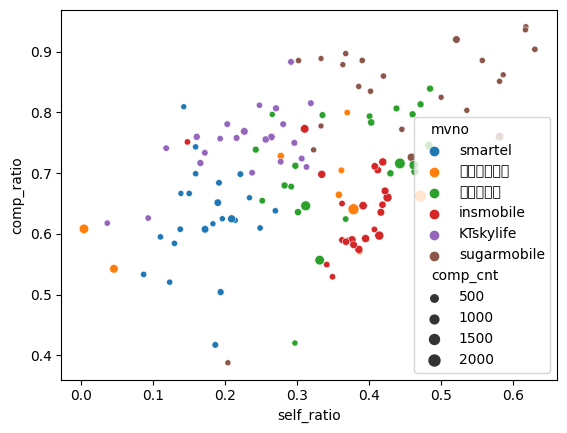

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'comp_cnt' to float64
df_nozero['comp_cnt'] = df_nozero['comp_cnt'].astype('float64')

sns.scatterplot(data=df_nozero, x="self_ratio", y="comp_ratio", size="comp_cnt", hue="mvno")
plt.show()


/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  func(*args, **kwargs)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from current font.
  func(*args, **kwargs)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  func(*args, **kwargs)
/Users/ringokwon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from current font.
  func(*args, **kwargs)
/Users/ringokwon/Library/Python/3.11/lib/python/sit

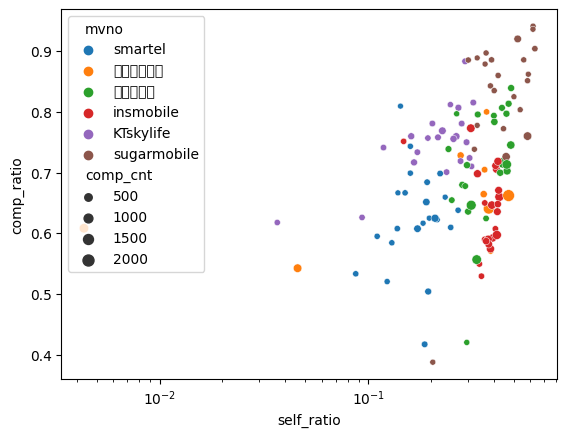

In [47]:
# log scale of scatter  plot of self_ratio and comp_ratio scatter size by comp_cnt
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_nozero, x="self_ratio", y="comp_ratio", size="comp_cnt", hue="mvno")
plt.xscale('log')

